# Translational Embeddings

### Knowledge Graph

Let $KG = (V, E, L; \vdash)$ be a knowledge graph with a set of
    vertices $V$, a set of edges $E \subseteq V \times V$, a label
    function $L: V \cup E \mapsto Lab$ that assigns labels from a set
    of labels $Lab$ to vertices and edges, and an inference relation
    $\vdash$.
    
**A knowledge graph embedding is a function** $f_\eta : L(V) \cup L(E) \mapsto \mathbb{R}^n$. That is, the function takes elements from the set $ L(V) \cup L(E) \subseteq Lab$ and gets elements in $\mathbb{R}^n$, where $n$ is the _embedding size_.

### TransE idea
TransE aims to model multirelational data by representing relationships as **translations** in the following way:

Consider an edge is the graph of the form $(h, \ell, t)$, where $h$ is the head of the edge, $\ell$ is the type of relation and $t$ is the tail of the edge. Let's denote the corresponding embeddings as $\boldsymbol{h}$, $\boldsymbol{\ell}$ and $\boldsymbol{t}$. TransE learns the embeddings such that: 
$$\boldsymbol{h} + \boldsymbol{\ell} \approx \boldsymbol{t}$$

### Objective function
TransE minimizes the following objective function: $$
\mathcal{L}=\sum_{(h, \ell, t) \in S} \sum_{\left(h^{\prime}, \ell, t^{\prime}\right) \in S_{(h, \ell, t)}^{\prime}}\left[\gamma+d(\boldsymbol{h}+\boldsymbol{\ell}, \boldsymbol{t})-d\left(\boldsymbol{h}^{\prime}+\boldsymbol{\ell}, \boldsymbol{t}^{\prime}\right)\right]_{+}
$$

Where $d(\boldsymbol{h}+\boldsymbol{\ell}, \boldsymbol{t})$ is the _dissimilarity_ score of a positive edge. Furthermore, $d\left(\boldsymbol{h}^{\prime}+\boldsymbol{\ell}, \boldsymbol{t}^{\prime}\right)$ is the _dissimilarity_ score for a negative triple obtained by corrupting either the head or tail (but not both) of a positive triple. In this way, TransE favors lower scores for positive edges and big scores for negative edges. 

Regarding the parameter $\gamma$, it is used to enforce that the score of a positive edge is different (lower) than the score of a negative edge by at least $\gamma$.

In [35]:
import sys
sys.path.append("../../../")

import torch as th
#import logging
import numpy as np
import pickle as pkl
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt

from mowl.datasets.ppi_yeast import PPIYeastSlimDataset

from mowl.embeddings.graph_based.translational.model import TranslationalOnt

In [36]:
dataset = PPIYeastSlimDataset()
    
modelE = TranslationalOnt(
        dataset, 
        parsing_method = "dl2vec", 
        trans_method = "transE",
        embedding_dim = 100,
        epochs = 32,
        batch_size = 256,
        bidirectional_taxonomy = True
    )
    


DEBUG:root:BID IS: True
DEBUG:root:BID IS: True


In [37]:
modelE.train()

INFO: Number of ontology classes: 11020
INFO: Number of ontology classes: 3610


DEBUG:root:Traininig entities: 11020, relations 10. Testing entities: 3610, relations 1.


Training epochs on cuda:   0%|          | 0/32 [00:00<?, ?epoch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

In [38]:
transE_embeddings = modelE.model.entity_representations[0](indices=None).cpu().detach().numpy()
protE_embeddings = {}

for node, idx in modelE.entities_idx.items():
    if node.startswith("4932"):
        protE_embeddings[node] = transE_embeddings[idx]
        
with open("data/protE_emb", "wb") as file:
    pkl.dump(protE_embeddings, file)

In [39]:
with open("data/protE_emb", "rb") as file:
    protE_embeddings = pkl.load(file)

ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]

In [40]:
ec_dict = {}
for prot in ec_numbers:
    if prot in protE_embeddings:
        ec_dict[prot] = protE_embeddings[prot]
        
size = modelE.embedding_dim
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

X = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

Performing t-SNE using 8 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 171 of 1712
 - point 342 of 1712
 - point 513 of 1712
 - point 684 of 1712
 - point 855 of 1712
 - point 1026 of 1712
 - point 1197 of 1712
 - point 1368 of 1712
 - point 1539 of 1712
 - point 1710 of 1712
Done in 0.00 seconds (sparsity = 0.068985)!
Learning embedding...
Iteration 51: error is 76.139155 (50 iterations in 0.00 seconds)
Iteration 101: error is 76.012405 (50 iterations in 0.00 seconds)
Iteration 151: error is 76.007142 (50 iterations in 1.00 seconds)
Iteration 201: error is 76.008412 (50 iterations in 0.00 seconds)
Iteration 251: error is 76.006414 (50 iterations in 0.00 seconds)
Iteration 301: error is 1.875940 (50 iterations in 0.00 seconds)
Iteration 351: error is 1.530794 (50 iterations in 0.00 seconds)
Iteration 401: error is 1.412144 (50 iterations in 0.00 seconds)
Iteration 451: error is 1.358956 (50 iterations in

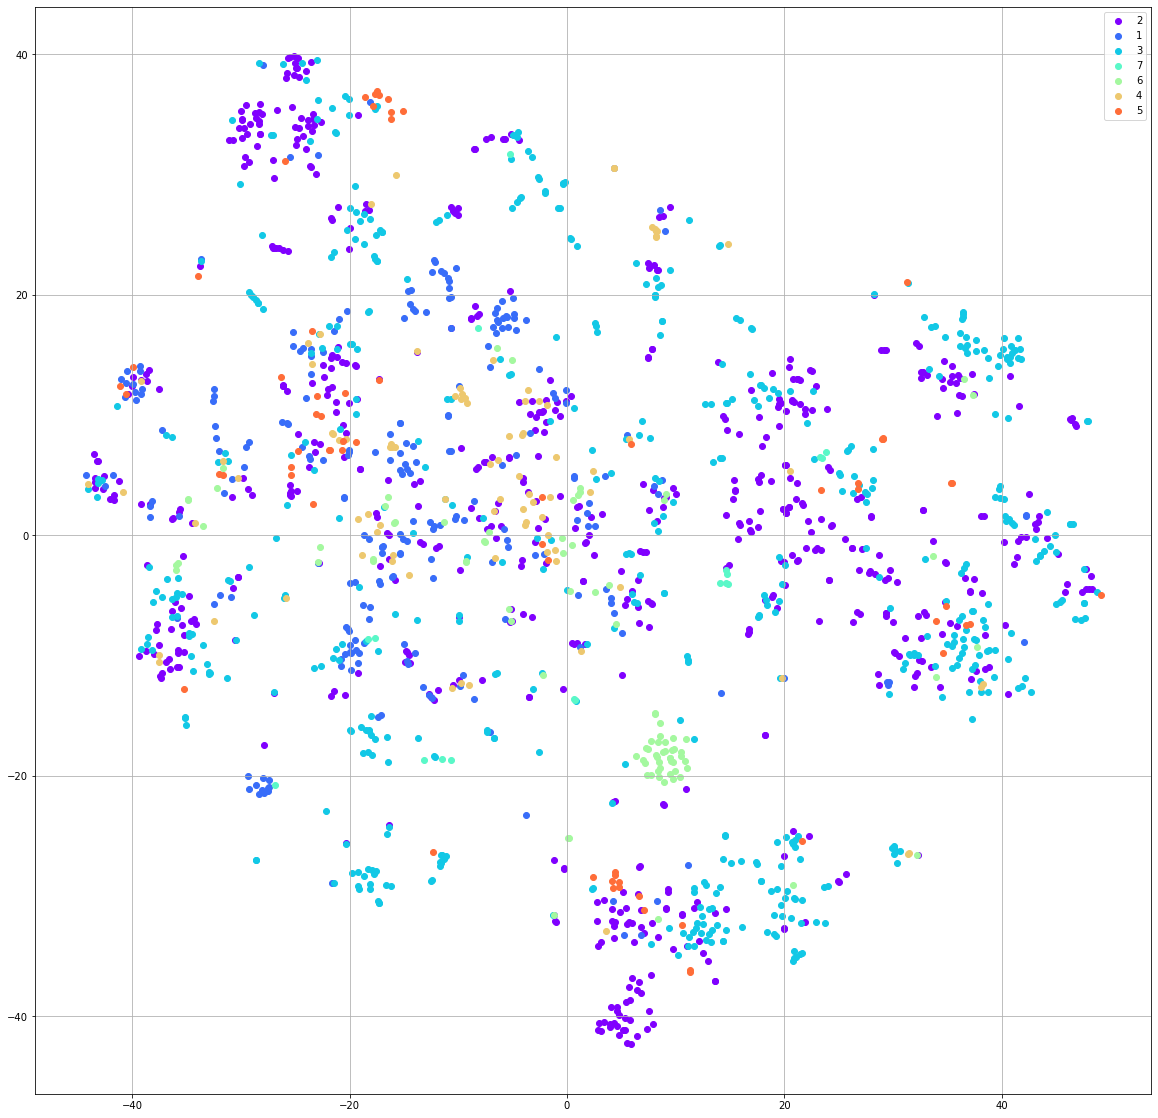

In [54]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.savefig('data/fig_transE.jpg')

plt.show()

## TransH

In [43]:
dataset = PPIYeastSlimDataset()
    
modelH = TranslationalOnt(
        dataset, 
        parsing_method = "dl2vec", 
        trans_method = "transH",
        embedding_dim = 100,
        epochs = 32,
        batch_size = 256,
        bidirectional_taxonomy = True
    )

DEBUG:root:BID IS: True
DEBUG:root:BID IS: True


In [44]:
modelH.train()

INFO: Number of ontology classes: 11020
INFO: Number of ontology classes: 3610


DEBUG:root:Traininig entities: 11020, relations 10. Testing entities: 3610, relations 1.


Training epochs on cuda:   0%|          | 0/32 [00:00<?, ?epoch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

In [45]:
transH_embeddings = modelH.model.entity_representations[0](indices=None).cpu().detach().numpy()
protH_embeddings = {}

for node, idx in modelH.entities_idx.items():
    if node.startswith("4932"):
        protH_embeddings[node] = transH_embeddings[idx]
        
with open("data/protH_emb", "wb") as file:
    pkl.dump(protH_embeddings, file)

In [46]:
ec_dict_H = {}
for prot in ec_numbers:
    if prot in protH_embeddings:
        ec_dict_H[prot] = protH_embeddings[prot]
        
size = modelH.embedding_dim
embedsH = np.zeros((len(ec_dict_H), size), dtype=np.float32)

for i, emb in enumerate(ec_dict_H.values()):
    embedsH[i, :] = emb
nodemapH = {}
for i, m in enumerate(ec_dict_H.keys()):
    nodemapH[i] = m
    

XH = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embedsH)

Performing t-SNE using 8 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 171 of 1712
 - point 342 of 1712
 - point 514 of 1712
 - point 684 of 1712
 - point 856 of 1712
 - point 1027 of 1712
 - point 1199 of 1712
 - point 1368 of 1712
 - point 1539 of 1712
 - point 1710 of 1712
Done in 0.00 seconds (sparsity = 0.074302)!
Learning embedding...
Iteration 51: error is 66.211170 (50 iterations in 0.00 seconds)
Iteration 101: error is 63.751064 (50 iterations in 0.00 seconds)
Iteration 151: error is 63.428983 (50 iterations in 0.00 seconds)
Iteration 201: error is 63.368496 (50 iterations in 1.00 seconds)
Iteration 251: error is 63.361506 (50 iterations in 0.00 seconds)
Iteration 301: error is 1.119179 (50 iterations in 0.00 seconds)
Iteration 351: error is 0.854728 (50 iterations in 0.00 seconds)
Iteration 401: error is 0.767427 (50 iterations in 0.00 seconds)
Iteration 451: error is 0.738417 (50 iterations in

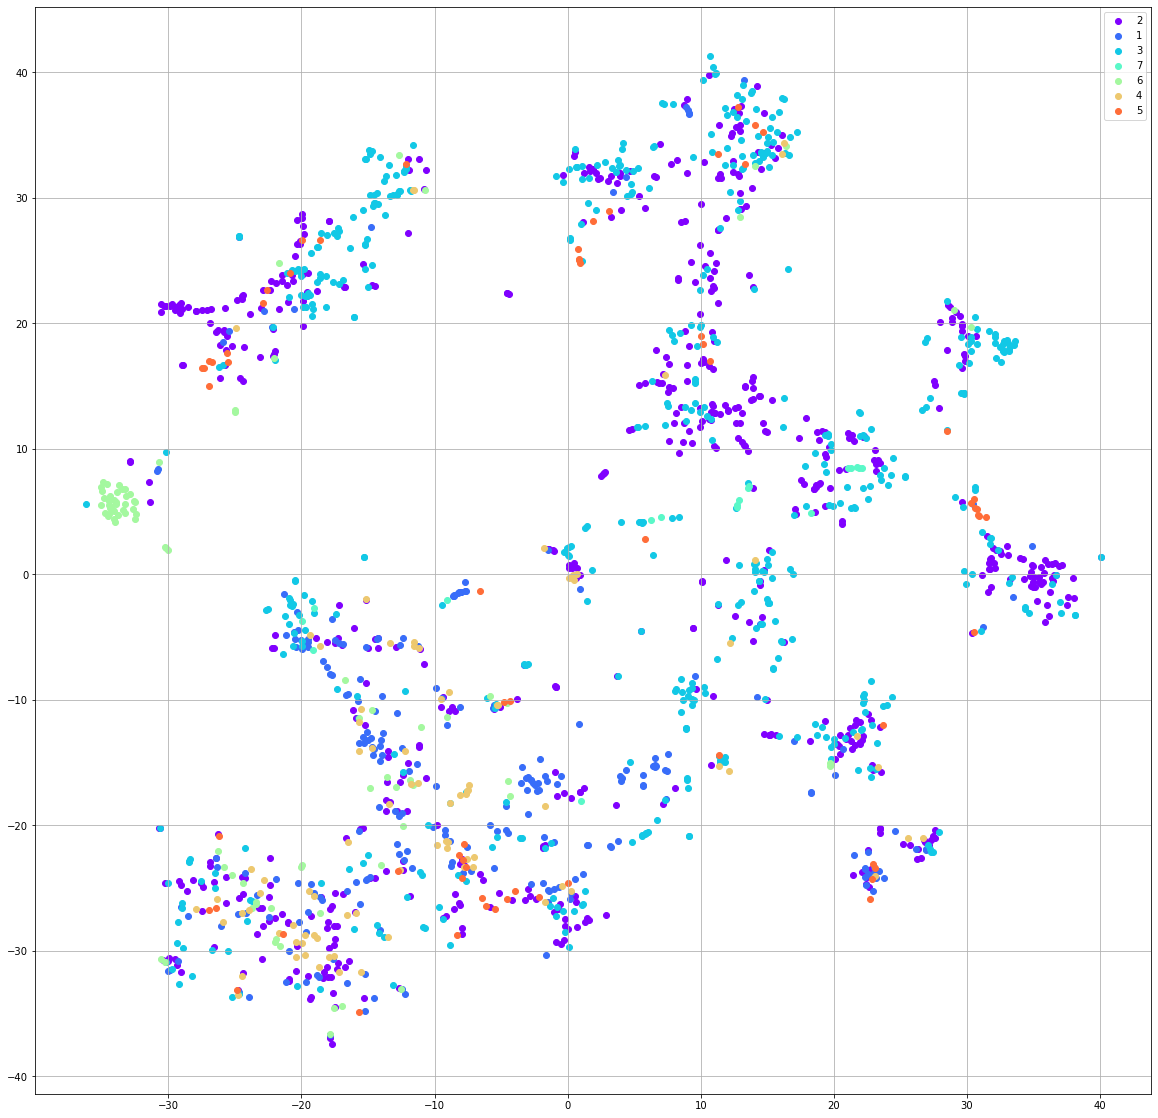

In [55]:
classes = {'0': [[], []]}
for item in nodemapH.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(XH[k, 0])
        classes[ec][1].append(XH[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.savefig('data/fig_transH.jpg')

plt.show()

## TransR

In [48]:
dataset = PPIYeastSlimDataset()
    
modelR = TranslationalOnt(
        dataset, 
        parsing_method = "dl2vec", 
        trans_method = "transR",
        embedding_dim = 100,
        epochs = 32,
        batch_size = 256,
        bidirectional_taxonomy = True
    )

DEBUG:root:BID IS: True
DEBUG:root:BID IS: True


In [49]:
modelR.train()

INFO: Number of ontology classes: 11020
INFO: Number of ontology classes: 3610


DEBUG:root:Traininig entities: 11020, relations 10. Testing entities: 3610, relations 1.


Training epochs on cuda:   0%|          | 0/32 [00:00<?, ?epoch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

Training batches on cuda:   0%|          | 0/974 [00:00<?, ?batch/s]

In [50]:
transR_embeddings = modelR.model.entity_representations[0](indices=None).cpu().detach().numpy()
protR_embeddings = {}

for node, idx in modelR.entities_idx.items():
    if node.startswith("4932"):
        protR_embeddings[node] = transR_embeddings[idx]
        
with open("data/protR_emb", "wb") as file:
    pkl.dump(protR_embeddings, file)

In [51]:
ec_dict_R = {}
for prot in ec_numbers:
    if prot in protR_embeddings:
        ec_dict_R[prot] = protR_embeddings[prot]
        
size = modelR.embedding_dim
embedsR = np.zeros((len(ec_dict_R), size), dtype=np.float32)

for i, emb in enumerate(ec_dict_R.values()):
    embedsR[i, :] = emb
nodemapR = {}
for i, m in enumerate(ec_dict_R.keys()):
    nodemapR[i] = m
    

XR = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embedsR)

Performing t-SNE using 8 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 171 of 1712
 - point 342 of 1712
 - point 513 of 1712
 - point 684 of 1712
 - point 855 of 1712
 - point 1026 of 1712
 - point 1197 of 1712
 - point 1368 of 1712
 - point 1539 of 1712
 - point 1710 of 1712
Done in 0.00 seconds (sparsity = 0.067122)!
Learning embedding...
Iteration 51: error is 74.465334 (50 iterations in 0.00 seconds)
Iteration 101: error is 74.438929 (50 iterations in 0.00 seconds)
Iteration 151: error is 74.447593 (50 iterations in 0.00 seconds)
Iteration 201: error is 74.426427 (50 iterations in 0.00 seconds)
Iteration 251: error is 73.910458 (50 iterations in 1.00 seconds)
Iteration 301: error is 1.601166 (50 iterations in 0.00 seconds)
Iteration 351: error is 1.350794 (50 iterations in 0.00 seconds)
Iteration 401: error is 1.271399 (50 iterations in 0.00 seconds)
Iteration 451: error is 1.236197 (50 iterations in

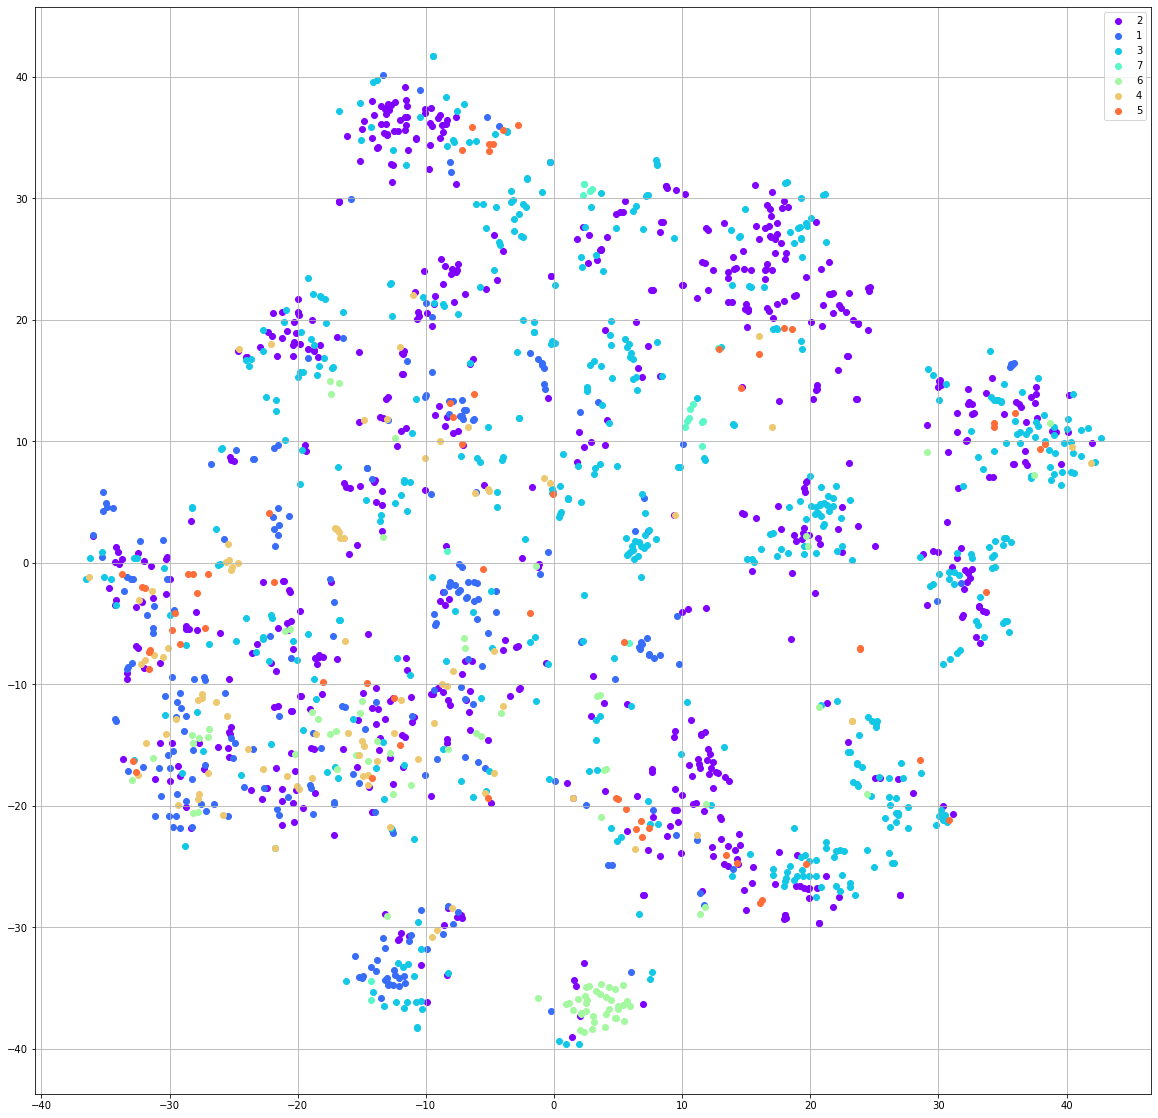

In [56]:
classes = {'0': [[], []]}
for item in nodemapR.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(XR[k, 0])
        classes[ec][1].append(XR[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.savefig('data/fig_transR.jpg')

plt.show()

In [9]:
resultsR = modelR.evaluate()

INFO: Number of ontology classes: 3610


DEBUG:root:LEN OF TEST TRIPLES: 24080
given. This means you probably forgot to pass (at least) the training triples. Try:

    additional_filter_triples=[dataset.training.mapped_triples]

Or if you want to use the Bordes et al. (2013) approach to filtering, do:

    additional_filter_triples=[
        dataset.training.mapped_triples,
        dataset.validation.mapped_triples,
    ]



Evaluating on cuda:   0%|          | 0.00/24.1k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 34.62s seconds


In [11]:
resultsR.hits_at_k

{'head': {'pessimistic': {1: 8.305647840531562e-05,
   3: 0.016777408637873754,
   5: 0.03446843853820598,
   10: 0.07379568106312293},
  'realistic': {1: 8.305647840531562e-05,
   3: 0.016777408637873754,
   5: 0.03446843853820598,
   10: 0.07379568106312293},
  'optimistic': {1: 8.305647840531562e-05,
   3: 0.016777408637873754,
   5: 0.03446843853820598,
   10: 0.07379568106312293}},
 'both': {'pessimistic': {1: 6.22923588039867e-05,
   3: 0.01665282392026578,
   5: 0.034011627906976746,
   10: 0.07331810631229235},
  'realistic': {1: 6.22923588039867e-05,
   3: 0.01665282392026578,
   5: 0.034011627906976746,
   10: 0.07331810631229235},
  'optimistic': {1: 6.22923588039867e-05,
   3: 0.01665282392026578,
   5: 0.034011627906976746,
   10: 0.07331810631229235}},
 'tail': {'pessimistic': {1: 4.152823920265781e-05,
   3: 0.016528239202657807,
   5: 0.03355481727574751,
   10: 0.0728405315614618},
  'realistic': {1: 4.152823920265781e-05,
   3: 0.016528239202657807,
   5: 0.0335548172